In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


warnings.filterwarnings('ignore')
import sklearn

In [45]:
df = pd.read_csv('/content/bikeshare.csv')

In [46]:
df.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed,dteday,cnt
0,1,0,1,0,0,6,1,1,-1.334609,0.947345,-1.553844,2011-01-01,16
1,1,0,1,1,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,40
2,1,0,1,2,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,32
3,1,0,1,3,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,13
4,1,0,1,4,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,1


In [47]:
df = df.drop('dteday', axis=1)

In [48]:
#1

# Define features (X) and target (y)
X = df.drop('cnt', axis=1)
y = df['cnt']

#2
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [49]:
#2.1, 2.2

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1000)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_hat = rf_model.predict(X_test)

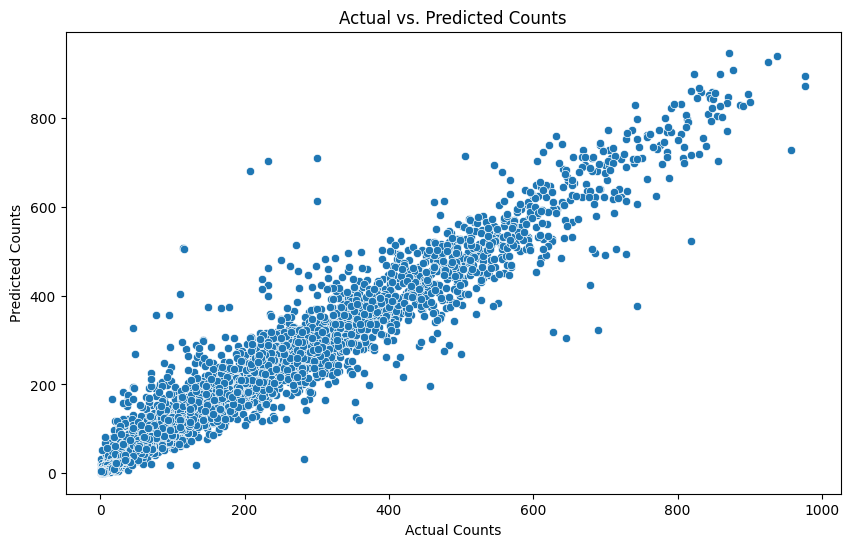

In [50]:
#2.3, 2.4

# Construct a data frame named df_predictions
df_predictions = pd.DataFrame({'y_test': y_test, 'y_hat': y_hat})

# Visualize actual vs predicted counts
plt.figure(figsize=(10, 6))
sns.scatterplot(x='y_test', y='y_hat', data=df_predictions)
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
plt.title('Actual vs. Predicted Counts')
plt.show()



In [51]:
#2.5

# Evaluate the model
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_hat)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")

R-squared: 0.9387102049387827
RMSE: 44.999929130270075


In [52]:
#3

# Define the parameter grid
my_param_grid = {'n_estimators':[100,200], 'max_features':['log2', 'sqrt'], 'max_depth':[10,None]}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=my_param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train a new model with the best hyperparameters
best_rf_model = RandomForestRegressor(random_state=1000, **best_params)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_hat_best = best_rf_model.predict(X_test)

# Evaluate the best model
r2_best = r2_score(y_test, y_hat_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_hat_best))

print(f"Best Model R-squared: {r2_best}")
print(f"Best Model RMSE: {rmse_best}")

# Determine tree characteristics
print(f"Max Depth of Trees: {best_params['max_depth']}")
print(f"Max Features Considered for Splitting: {best_params['max_features']}")


Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best Model R-squared: 0.9041131980397425
Best Model RMSE: 56.28558215603691
Max Depth of Trees: None
Max Features Considered for Splitting: log2


The random forest is using bushy trees due to the limited amount of features considered at each split. The feature space in general is small and the random forest can only pick from a handful of features at each split.

In [53]:
#4

# Using Cross-Validation for R2 estimation
cv_scores = cross_val_score(best_rf_model, X_test, y_test, cv=5, scoring='r2')
cv_r2 = np.mean(cv_scores)
print(f"Cross-Validation R-squared: {cv_r2}")

# Using Out-of-Bag (OOB) score for R2 estimation
best_rf_model_oob = RandomForestRegressor(random_state=1000, **best_params, oob_score=True)
best_rf_model_oob.fit(X_train, y_train)
oob_r2 = best_rf_model_oob.oob_score_
print(f"Out-of-Bag R-squared: {oob_r2}")

# Comparing the results
print("\nComparison:")
print(f"Test R-squared (using best model): {r2_best}")
print(f"Cross-Validation R-squared: {cv_r2}")
print(f"Out-of-Bag R-squared: {oob_r2}")

Cross-Validation R-squared: 0.8488006949052576
Out-of-Bag R-squared: 0.9048763622695346

Comparison:
Test R-squared (using best model): 0.9041131980397425
Cross-Validation R-squared: 0.8488006949052576
Out-of-Bag R-squared: 0.9048763622695346


OOB is doing slightly better in terms of r-squared than CV. This indicates that OOB's predictions are closer to the actual observation and is explaining more variability between the independednt variables and target variable.

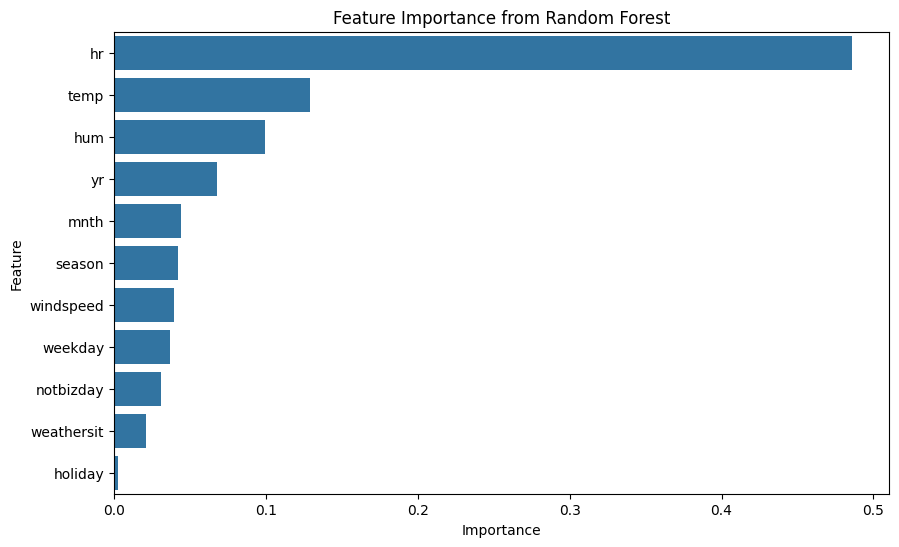


Top 5 Features from Random Forest:
  Feature  Importance
3      hr    0.485996
8    temp    0.128994
9     hum    0.099467
1      yr    0.067937
2    mnth    0.044160

Top 5 Coefficients from Linear Regression:
   Feature  Coefficient
1       yr    79.375152
8     temp    53.296473
9      hum   -36.902011
4  holiday   -25.678095
0   season    20.622651


In [54]:
#5

feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()


# Linear Regression for comparison
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
lr_coefficients = lr_coefficients.sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop 5 Features from Random Forest:")
print(feature_importance_df.head(5))

print("\nTop 5 Coefficients from Linear Regression:")
print(lr_coefficients.head(5))

# Find features important in RF but not significant in linear regression
rf_top_features = set(feature_importance_df.head(5)['Feature'])
lr_top_features = set(lr_coefficients.head(5)['Feature'])

diff = rf_top_features - lr_top_features



{mnth, hr} are among the top features for Random forest, but do not appear in the higher influencing variables for linear regression. One reason could be that the random forest picks up non linear relationships between variables and that might be the case for these variables. Another thing is random forests accounts for variables that have an affect on the overall model accuracy, where as linear regression isolates the variable in terms of linear impact witht he target variable.